In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# --- Device Config ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Hyperparameters ---
BATCH_SIZE = 128
LR = 1e-3
EPOCHS_TEACHER = 10  # Quick pre-training
EPOCHS_STUDENT = 5  # Quick demonstration
TEMP = 0.07

# --- Data Preparation (CIFAR-10) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using device: cuda


In [13]:
class ConvEncoder(nn.Module):
    """Simple CNN Encoder outputting a flat feature vector."""
    def __init__(self, feature_dim=128):
        super().__init__()
        # Input: 3 x 32 x 32
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # -> 8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # -> 4x4
        )
        self.flat_dim = 128 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class ModelWrapper(nn.Module):
    """Wraps Encoder, Projection Head, and Classifier."""
    def __init__(self, num_classes=10):
        super().__init__()
        self.encoder = ConvEncoder(feature_dim=128)
        
        # Projection Head (for Contrastive Loss)
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64) 
        )
        
        # Classifier (for Teacher Supervision / Eval)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        feats = self.encoder(x)       # (Batch, 128)
        proj = self.projector(feats)  # (Batch, 64)
        logits = self.classifier(feats) # (Batch, 10)
        return feats, proj, logits

In [23]:
class LogitWeightedSupCRDLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, temperature=0.07, eps=1e-8):
        """
        Implementation of Logit-Weighted SupCRD (Decoupled Feature Distillation).
        
        Args:
            alpha (float): Global scaler for the Pull Force (Target Class).
            beta (float): Global scaler for the Push Force (Non-Target Classes).
            temperature (float): Contrastive temperature.
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.tau = temperature
        self.eps = eps

    def forward(self, student_features, teacher_features, teacher_logits, labels):
        """
        Args:
            student_features: (Batch, Dim) - Anchor s_i
            teacher_features: (Batch, Dim) - Targets t_j
            teacher_logits: (Batch, Num_Classes) - For computing p^T
            labels: (Batch) - Ground truth y_i
        """
        batch_size = student_features.shape[0]
        device = student_features.device

        # 1. Normalize features (Standard CRD setup)
        s_norm = F.normalize(student_features, dim=1)
        t_norm = F.normalize(teacher_features, dim=1)

        # 2. Similarity Matrix (Student vs Teacher)
        # sim(s_i, t_j) for all i, j
        sim_matrix = torch.matmul(s_norm, t_norm.T) / self.tau
        
        # Stability: Subtract max for numerical stability in exp
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - sim_max.detach()
        exp_sim = torch.exp(sim_matrix)

        # 3. Teacher Probabilities (Softmax)
        # p^T_i = softmax(z^T_i / T_kd) - usually T_kd=1 for this weighting
        teacher_probs = F.softmax(teacher_logits, dim=1) # (Batch, Classes)

        # 4. Construct Masks
        # Positive Mask: y_j == y_i
        # Negative Mask: y_j != y_i
        labels = labels.view(-1, 1)
        mask_pos = torch.eq(labels, labels.T).float().to(device)
        mask_neg = 1.0 - mask_pos

        # 5. Compute Weights (The core contribution of the paper)
        
        # --- Pull Weight (w_pull) ---
        # w_pull_i = alpha * p^T_i(y_i)
        # We need the probability the teacher assigned to the *correct* class for each anchor.
        p_target = torch.gather(teacher_probs, 1, labels).view(-1) # (Batch)
        w_pull = self.alpha * p_target # (Batch)
        
        # --- Push Weight (w_push) ---
        # w_push_ij = beta * (1 - p^T_i(y_j))
        # For each anchor i, we need p^T_i(class_of_sample_j).
        # We construct a matrix where entry [i, j] is p^T_i(y_j).
        target_labels_expand = labels.view(1, -1).expand(batch_size, -1) # (Batch, Batch)
        p_negative_class = torch.gather(teacher_probs, 1, target_labels_expand) # (Batch, Batch)
        
        w_push = self.beta * (1.0 - p_negative_class) # (Batch, Batch)

        # 6. Compute the Terms for the Loss Formula
        
        # Numerator Term: w_pull * Sum_{k in Pos} exp(sim)
        # Note: w_pull is scalar per anchor, acts on the sum.
        sum_pos_exp = (exp_sim * mask_pos).sum(dim=1)
        numerator_term = w_pull * sum_pos_exp

        # Denominator Part 2: Sum_{j in Neg} (w_push_ij * exp(sim))
        # Note: w_push varies per pair (i,j), so it is inside the sum.
        weighted_neg_exp = (exp_sim * w_push * mask_neg).sum(dim=1)

        # Denominator Total: Numerator_Term + Weighted_Negatives
        denominator_term = numerator_term + weighted_neg_exp

        # 7. Final Log-Likelihood
        # L = - log ( Num / Denom )
        loss = -torch.log((numerator_term + self.eps) / (denominator_term + self.eps))

        return loss.mean()
 

class ClassWeightedSupConDistillLoss(nn.Module):
    """
    YOUR CUSTOM LOSS:
    - Pulls positives weighted by alpha * P(Target)
    - Pushes negatives weighted by beta * (1 - P(Negative))
    """
    def __init__(self, alpha=50.0, beta=1.0, temperature=0.07):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.temp = temperature

    def forward(self, student_proj, teacher_proj, teacher_logits, labels):
        batch_size = student_proj.shape[0]

        # Normalize
        s_norm = F.normalize(student_proj, dim=1)
        t_norm = F.normalize(teacher_proj, dim=1)

        # Similarity (Student vs Teacher)
        # Entry [i, j] is sim(student_i, teacher_j)
        sim_matrix = torch.matmul(s_norm, t_norm.T) 

        # Mask: True if label[i] == label[j]
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)

        # --- Dynamic Weighting Logic ---
        # 1. Get Teacher probabilities
        teacher_probs = F.softmax(teacher_logits, dim=1) # (Batch, Num_Classes)
        
        # 2. Gather prob of the *column* sample's class
        # We need the prob that Teacher assigns to class 'label[j]' for image 'i'
        # But for simplification in batch processing:
        # We approximate P_matrix[i, j] using the teacher's confidence on the target class of j
        target_labels = labels.view(1, -1).expand(batch_size, -1)
        p_matrix = torch.gather(teacher_probs, 1, target_labels)

        # 3. Calculate forces
        pos_weights = self.alpha * p_matrix
        neg_weights = self.beta * (1.0 - p_matrix)
        
        # 4. Combine
        weights = mask * pos_weights + (1.0 - mask) * neg_weights

        # --- Contrastive Calculation ---
        logits = (sim_matrix * weights) / self.temp
        
        # Stability trick
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        exp_logits = torch.exp(logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        
        # Mean log-likelihood over positive pairs
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()

class SupConLoss(nn.Module):
    """BASELINE: Standard Supervised Contrastive Loss (Student vs Student)"""
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, student_proj, labels):
        feats = F.normalize(student_proj, dim=1)
        sim_matrix = torch.matmul(feats, feats.T) / self.temp
        
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        # Remove self-contrast
        logits_mask = torch.scatter(torch.ones_like(mask), 1, 
                                    torch.arange(feats.shape[0]).view(-1, 1).to(device), 0)
        mask = mask * logits_mask
        
        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = sim_matrix - logits_max.detach()
        
        exp_logits = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_logits.sum(1, keepdim=True))
        
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        return -mean_log_prob_pos.mean()

In [15]:
def visualize_latents(model, loader, title="Latent Space"):
    """Runs t-SNE on model features and plots them."""
    model.eval()
    features_list = []
    labels_list = []
    num_samples = 2000 # Limit samples for speed
    count = 0
    
    print(f"[{title}] Extracting features...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats, _, _ = model(images)
            feats = feats.view(feats.size(0), -1).cpu()
            
            features_list.append(feats)
            labels_list.append(labels)
            
            count += images.size(0)
            if count >= num_samples:
                break

    X = torch.cat(features_list, dim=0).numpy()[:num_samples]
    y = torch.cat(labels_list, dim=0).numpy()[:num_samples]

    print(f"[{title}] Running t-SNE... (this may take a few seconds)")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)

    plt.figure(figsize=(10, 8))
    cifar_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    
    sns.scatterplot(
        x=X_embedded[:, 0], y=X_embedded[:, 1], 
        hue=y, palette='tab10', legend='full', alpha=0.7
    )
    plt.legend(title='Classes', labels=cifar_classes, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"{title} (t-SNE)")
    plt.tight_layout()
    plt.show()

In [32]:
def train_teacher(epochs=5):
    # Bumped epochs to 5 to ensure teacher has better "dark knowledge"
    model = ModelWrapper(num_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    print(f"--- Pre-training Teacher ({epochs} epochs) ---")
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0; total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            _, _, logits = model(images)
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        print(f"Teacher Epoch {epoch+1}: Loss {total_loss/len(train_loader):.3f} | Acc {100.*correct/total:.1f}%")
    return model

def train_student(teacher_model, mode="decoupled", epochs=5, alpha=1.0, beta=1.0, temperature=0.07):
    """
    Args:
        mode: 'decoupled' (New PDF method) or 'supcon' (Baseline)
        alpha: Weight for the Pull force (Target Class)
        beta: Weight for the Push force (Non-Target Classes)
    """
    student = ModelWrapper(num_classes=10).to(device)
    optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
    
    # Online Linear Probe (Evaluator)
    probe_head = nn.Linear(128, 10).to(device) 
    probe_opt = torch.optim.Adam(probe_head.parameters(), lr=1e-3)
    probe_crit = nn.CrossEntropyLoss()

    # --- SELECT LOSS FUNCTION ---
    if mode == "decoupled":
        # The new Logit-Weighted SupCRD from the PDF
        # We pass alpha/beta here to control the "knobs"
        criterion = LogitWeightedSupCRDLoss(alpha=alpha, beta=beta, temperature=temperature)
        print(f"\n>>> Training DECOUPLED DISTILLATION (PDF Method) | Alpha={alpha}, Beta={beta} <<<")
    else:
        # Standard Baseline
        criterion = SupConLoss(temperature=temperature)
        print(f"\n>>> Training BASELINE SUPCON <<<")

    for epoch in range(epochs):
        student.train()
        probe_head.train()
        total_loss = 0; probe_acc = 0; total_samples = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 1. Forward Student
            s_feats, s_proj, _ = student(images)
            
            # 2. Compute Loss
            if mode == "decoupled":
                # Need Teacher info for the Decoupled loss
                with torch.no_grad():
                    _, t_proj, t_logits = teacher_model(images)
                
                # Passes all required data to the new loss
                loss = criterion(
                    student_features=s_proj,
                    teacher_features=t_proj,
                    teacher_logits=t_logits,
                    labels=labels
                )
            else:
                # Baseline only uses Student Projections and Labels
                loss = criterion(s_proj, labels)

            # 3. Optimize Student
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. Optimize Linear Probe (on detached features)
            # This measures representation quality without updating the encoder
            probe_logits = probe_head(s_feats.detach()) 
            p_loss = probe_crit(probe_logits, labels)
            
            probe_opt.zero_grad()
            p_loss.backward()
            probe_opt.step()
            
            total_loss += loss.item()
            _, preds = probe_logits.max(1)
            probe_acc += preds.eq(labels).sum().item()
            total_samples += labels.size(0)
            
        avg_loss = total_loss / len(train_loader)
        avg_acc = 100. * probe_acc / total_samples
        print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f} | Probe Acc: {avg_acc:.2f}%")
        
    return student

--- Pre-training Teacher (10 epochs) ---
Teacher Epoch 1: Loss 1.412 | Acc 49.0%
Teacher Epoch 2: Loss 0.990 | Acc 65.1%
Teacher Epoch 3: Loss 0.835 | Acc 70.8%
Teacher Epoch 4: Loss 0.722 | Acc 74.7%
Teacher Epoch 5: Loss 0.633 | Acc 77.8%
Teacher Epoch 6: Loss 0.563 | Acc 80.4%
Teacher Epoch 7: Loss 0.501 | Acc 82.4%
Teacher Epoch 8: Loss 0.446 | Acc 84.5%
Teacher Epoch 9: Loss 0.388 | Acc 86.5%
Teacher Epoch 10: Loss 0.342 | Acc 88.0%

>>> Training CUSTOM DISTILLATION (Mine) <<<
Epoch 1: Loss: 2.6757 | Probe Acc: 12.15%
Epoch 2: Loss: 2.6352 | Probe Acc: 22.70%
Epoch 3: Loss: 2.6337 | Probe Acc: 27.95%
Epoch 4: Loss: 2.6320 | Probe Acc: 32.46%
Epoch 5: Loss: 2.6311 | Probe Acc: 35.37%
[Custom Distillation] Extracting features...
[Custom Distillation] Running t-SNE... (this may take a few seconds)


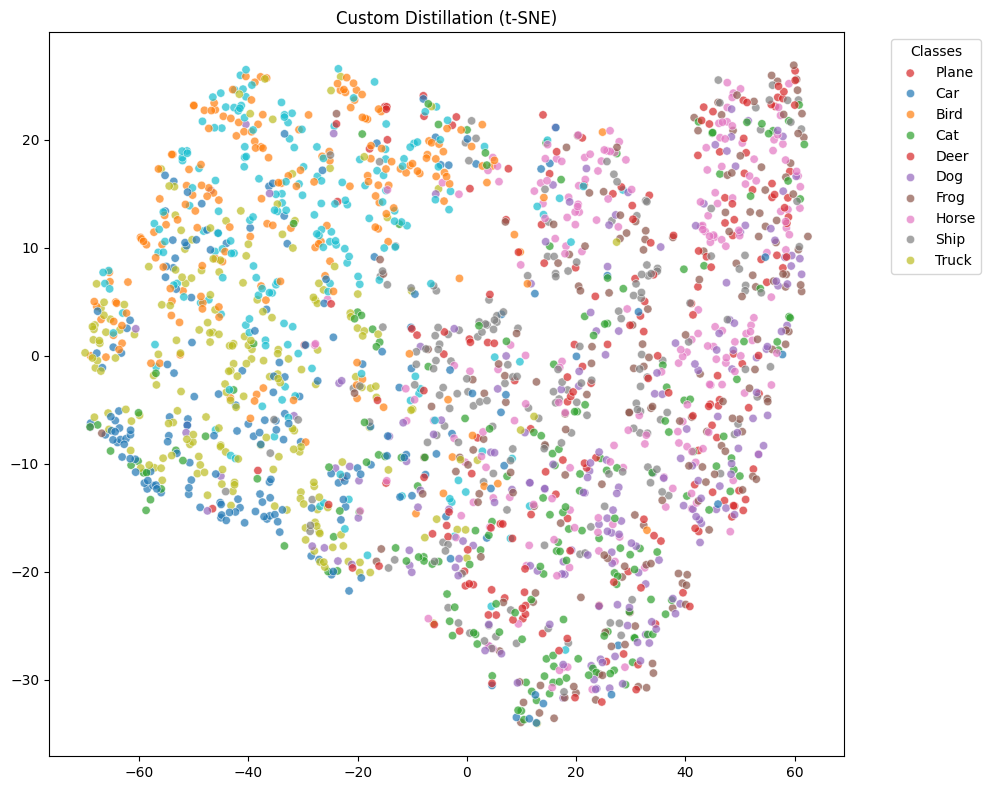


>>> Training BASELINE SUPCON <<<
Epoch 1: Loss: 4.3843 | Probe Acc: 36.64%
Epoch 2: Loss: 4.0299 | Probe Acc: 60.85%
Epoch 3: Loss: 3.8196 | Probe Acc: 69.45%
Epoch 4: Loss: 3.6818 | Probe Acc: 74.18%
Epoch 5: Loss: 3.5647 | Probe Acc: 77.44%
[Baseline SupCon] Extracting features...
[Baseline SupCon] Running t-SNE... (this may take a few seconds)


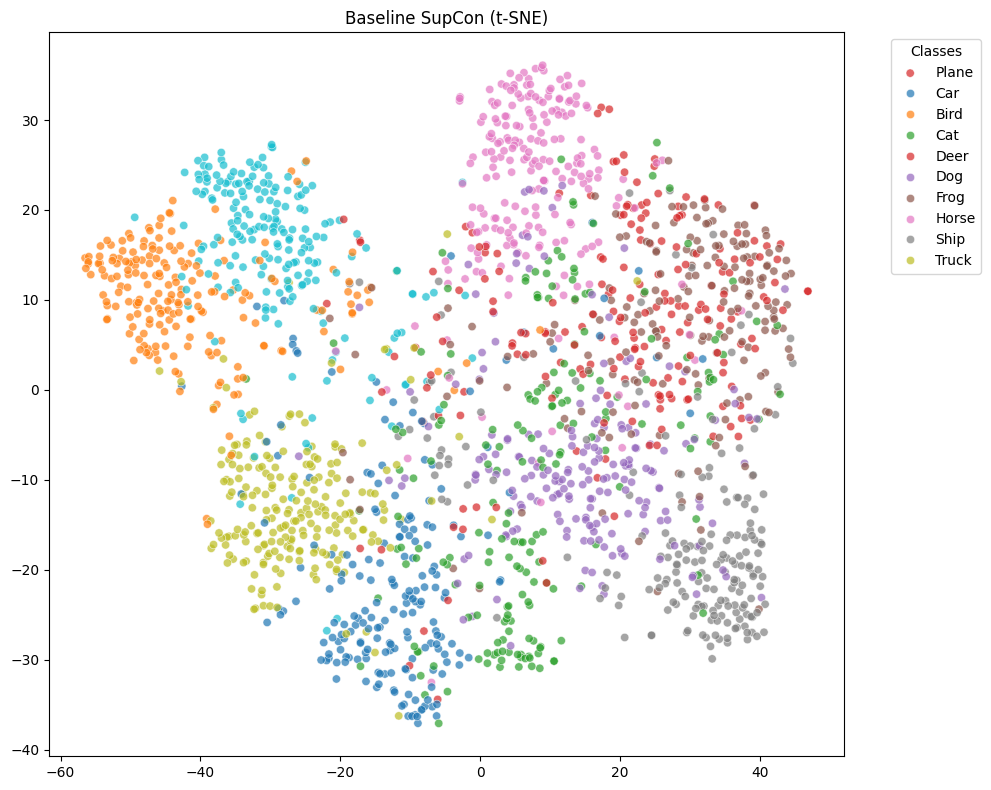

In [17]:
# 1. Train the Teacher
teacher = train_teacher(epochs=EPOCHS_TEACHER)
teacher.eval() # Freeze teacher




>>> Training DECOUPLED DISTILLATION (PDF Method) | Alpha=1.0, Beta=10.0 <<<
Epoch 1: Loss: 3.1648 | Probe Acc: 46.44%
Epoch 2: Loss: 2.1378 | Probe Acc: 67.02%
Epoch 3: Loss: 1.8060 | Probe Acc: 73.22%
Epoch 4: Loss: 1.6325 | Probe Acc: 76.51%
Epoch 5: Loss: 1.5114 | Probe Acc: 78.81%
[Custom Distillation] Extracting features...
[Custom Distillation] Running t-SNE... (this may take a few seconds)


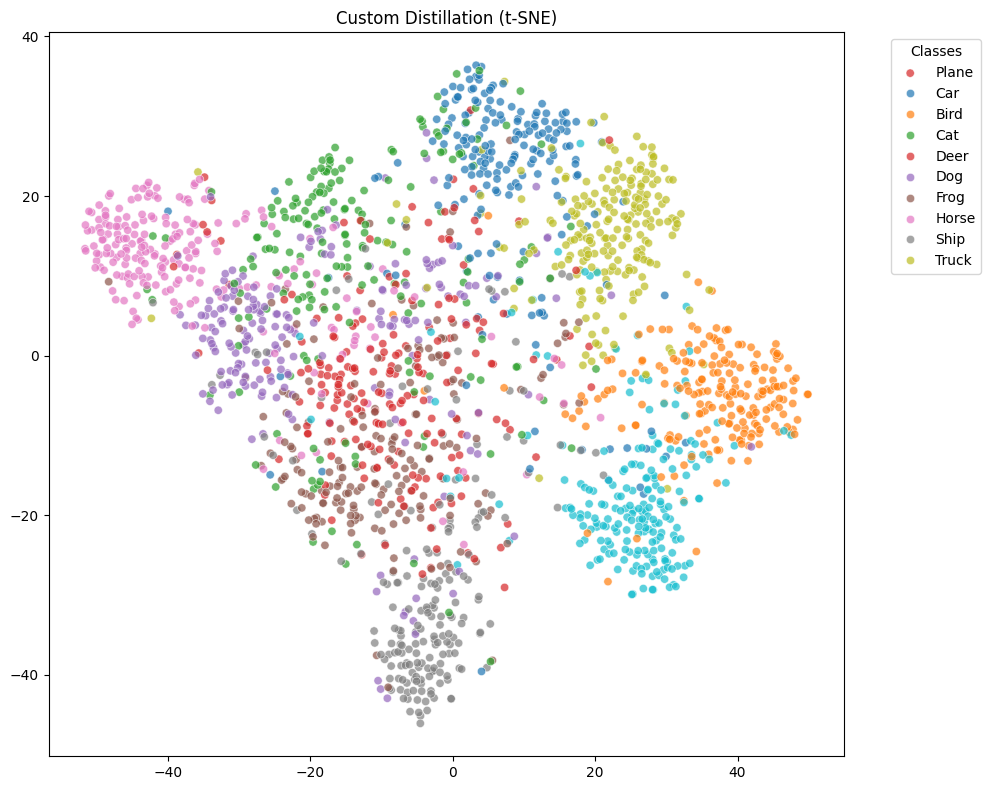

In [ ]:
# 2. Train Your Custom Student & Visualize
custom_student = train_student(teacher, mode="decoupled", epochs=EPOCHS_STUDENT, alpha=1.0, beta=10.0)
visualize_latents(custom_student, test_loader, title="Custom Distillation")

# # 3. Train Baseline Student & Visualize
# baseline_student = train_student(teacher, mode="supcon", epochs=EPOCHS_STUDENT)
# visualize_latents(baseline_student, test_loader, title="Baseline SupCon")


>>> Training DECOUPLED DISTILLATION (PDF Method) | Alpha=1.0, Beta=10.0 <<<
Epoch 1: Loss: 5.1620 | Probe Acc: 28.01%
Epoch 2: Loss: 3.1572 | Probe Acc: 52.96%
Epoch 3: Loss: 2.2642 | Probe Acc: 64.15%
Epoch 4: Loss: 1.5393 | Probe Acc: 69.92%
Epoch 5: Loss: 1.1446 | Probe Acc: 72.72%
[Custom Distillation] Extracting features...
[Custom Distillation] Running t-SNE... (this may take a few seconds)


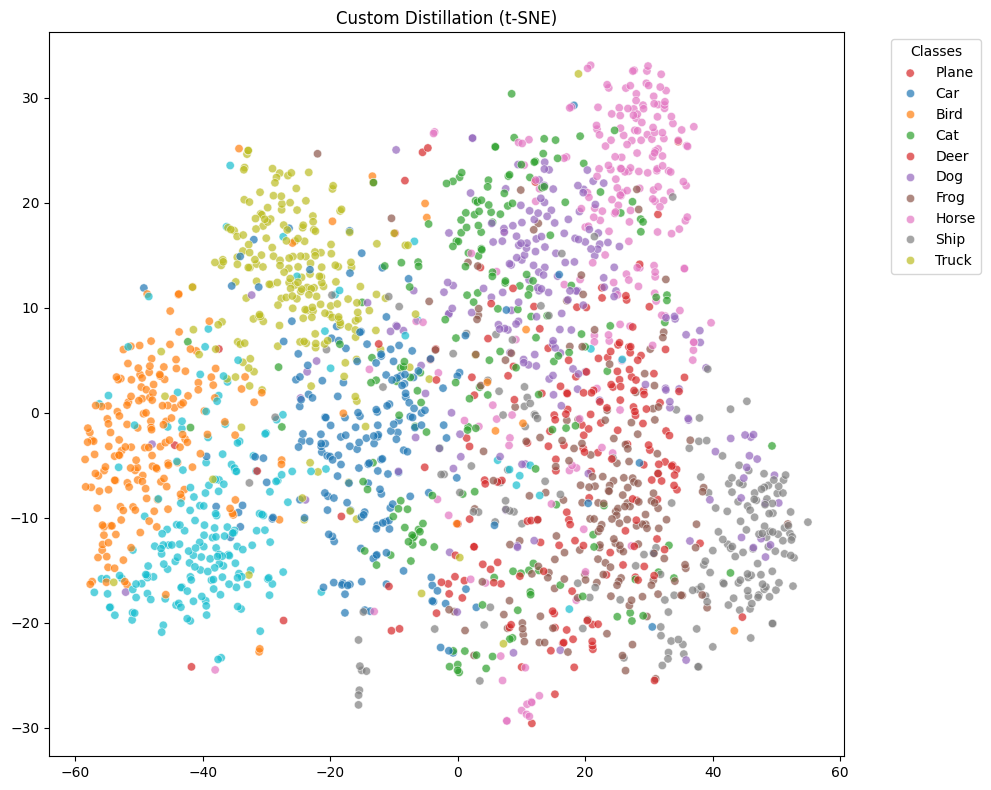

In [ ]:
# 2. Train Your Custom Student & Visualize
custom_student = train_student(teacher, mode="decoupled", epochs=EPOCHS_STUDENT, alpha=1.0, beta=10.0, temperature=0.0070000)
visualize_latents(custom_student, test_loader, title="Custom Distillation")

# # 3. Train Baseline Student & Visualize
# baseline_student = train_student(teacher, mode="supcon", epochs=EPOCHS_STUDENT)
# visualize_latents(baseline_student, test_loader, title="Baseline SupCon")